# San Francisco Restaurant Health Inspection Analysis

**Author:** Julian  
**Date:** February 2026  
**Data Source:** [San Francisco Open Data Portal](https://data.sfgov.org)

---

## Executive Summary

This analysis examines health inspection data from restaurants and food establishments in San Francisco to identify patterns in health code violations, risk categories, and compliance trends. The dataset contains **53,973 inspection records** across multiple years.

### Key Findings:

1. **High-Risk Violation Patterns**: The most common high-risk violations relate to improper food storage temperatures and inadequate handwashing facilities
2. **Geographic Hotspots**: Certain ZIP codes show significantly higher violation rates, suggesting targeted intervention opportunities
3. **Temporal Trends**: Inspection volumes and violation patterns vary seasonally, with peaks during summer months
4. **Repeat Offenders**: A small subset of establishments account for a disproportionate number of high-risk violations

5. **Business Performance Trends**: Analysis of improvement and decline patterns reveals success stories (businesses improving 10+ points) and concerning declines requiring intervention
### Business Impact:

- Public health officials can prioritize resources toward high-risk areas
- Restaurant owners can benchmark their compliance against city averages
- Policy makers can design targeted intervention programs

---

## Table of Contents

1. [Setup & Data Import](#1-setup--data-import)
2. [Data Overview & Quality Check](#2-data-overview--quality-check)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
4. [Risk Category Analysis](#4-risk-category-analysis)
5. [Geographic Analysis](#5-geographic-analysis)
6. [Temporal Trends](#6-temporal-trends)
7. [Violation Deep Dive](#7-violation-deep-dive)
8. [Business Performance Trends](#8-business-performance-trends-improvement--decline)
9. [Key Insights & Recommendations](#9-key-insights--recommendations)

---

## 1. Setup & Data Import

### 1.1 Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# API requests
import requests
from io import StringIO

# Configure visualization defaults
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


### 1.2 Load Data from SF Open Data API

The data is retrieved directly from San Francisco's Open Data Portal using their Socrata API. This ensures we're working with the most current information available.

In [26]:
def fetch_sf_inspection_data(batch_size=54000):
    """
    Fetch health inspection data from SF Open Data Portal.
    Uses batch processing to handle large datasets.
    
    Parameters:
    -----------
    batch_size : int
        Number of records to fetch per API call
    
    Returns:
    --------
    pd.DataFrame : Complete dataset with all inspection records
    """
    base_url = "https://data.sfgov.org/resource/pyih-qa8i.csv"
    offset = 0
    all_data = []
    
    print("Fetching data from SF Open Data Portal...")
    print(f"API Endpoint: {base_url}")
    
    try:
        while True:
            params = {
                "$limit": batch_size,
                "$offset": offset
            }
            
            response = requests.get(base_url, params=params, timeout=30)
            
            if response.status_code != 200:
                print(f"✗ Request failed with status code {response.status_code}")
                print(f"  Response: {response.text[:200]}")
                break
            
            # Check if response has content
            if not response.text or len(response.text.strip()) == 0:
                print("✗ Empty response received")
                break
            
            chunk = pd.read_csv(StringIO(response.text))
            
            if chunk.empty:
                print(f"  No more data at offset {offset:,}")
                break
            
            all_data.append(chunk)
            print(f"  ✓ Retrieved {len(chunk):,} rows (offset: {offset:,})")
            offset += batch_size
            
            # Break if we got less than expected (end of data)
            if len(chunk) < batch_size:
                break
    
    except requests.exceptions.RequestException as e:
        print(f"\n✗ Network error occurred: {e}")
        if all_data:
            print("  Returning partial data...")
        else:
            print("  No data retrieved before error.")
            raise
    
    # Check if we got any data
    if not all_data:
        raise ValueError(
            "No data was retrieved from the API. Possible reasons:\n"
            "  1. API endpoint may be down or changed\n"
            "  2. Network connectivity issues\n"
            "  3. API rate limiting\n\n"
            "Try loading from a local CSV file instead using:\n"
            "  sf_phi = pd.read_csv('path/to/your/local/file.csv')"
        )
    
    df = pd.concat(all_data, ignore_index=True)
    print(f"\n✓ Total records retrieved: {len(df):,}")
    print(f"✓ Columns: {len(df.columns)}")
    
    return df

# Option 1: Try to fetch from API
try:
    sf_phi = fetch_sf_inspection_data()
except Exception as e:
    print(f"\nAPI fetch failed: {e}")
    print("\n" + "="*60)
    print("ALTERNATIVE: Load from local CSV file")
    print("="*60)
    
    # Option 2: Load from local file if you have one saved
    # Uncomment and modify the path below:
    # sf_phi = pd.read_csv(r"E:\DATASETS\PUBLIC HEALTH\San_Francisco_Public_Health\Sf_Public_Health.csv")
    # print(f"✓ Loaded {len(sf_phi):,} rows from local file")
    
    raise  # Re-raise if no local file is available

Fetching data from SF Open Data Portal...
API Endpoint: https://data.sfgov.org/resource/pyih-qa8i.csv
✗ Request failed with status code 403
  Response: <html>
<head><title>403 Forbidden</title></head>
<body>
<center><h1>403 Forbidden</h1></center>
</body>
</html>


API fetch failed: No data was retrieved from the API. Possible reasons:
  1. API endpoint may be down or changed
  2. Network connectivity issues
  3. API rate limiting

Try loading from a local CSV file instead using:
  sf_phi = pd.read_csv('path/to/your/local/file.csv')

ALTERNATIVE: Load from local CSV file


ValueError: No data was retrieved from the API. Possible reasons:
  1. API endpoint may be down or changed
  2. Network connectivity issues
  3. API rate limiting

Try loading from a local CSV file instead using:
  sf_phi = pd.read_csv('path/to/your/local/file.csv')

### 1.3 Alternative: Load from Local File

If the API is unavailable, you can load from a previously saved CSV file:

In [2]:
sf_phi = pd.read_csv('Sf_Public_Health.csv')

---

## 2. Data Overview & Quality Check

### 2.1 Dataset Structure

In [3]:
# Display basic information
print("Dataset Shape:", sf_phi.shape)
print(f"\nRows: {sf_phi.shape[0]:,}")
print(f"Columns: {sf_phi.shape[1]}")
print("\n" + "="*60)
print("Column Information:")
print("="*60)
sf_phi.info()

Dataset Shape: (53973, 23)

Rows: 53,973
Columns: 23

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53973 entries, 0 to 53972
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   53973 non-null  int64  
 1   business_id                  53973 non-null  int64  
 2   business_name                53973 non-null  object 
 3   business_address             53973 non-null  object 
 4   business_city                53973 non-null  object 
 5   business_state               53973 non-null  object 
 6   business_postal_code         52787 non-null  object 
 7   business_latitude            27475 non-null  float64
 8   business_longitude           27475 non-null  float64
 9   business_location            27460 non-null  object 
 10  business_phone_number        17672 non-null  float64
 11  inspection_id                53973 non-null  object 
 12  

### 2.2 Data Dictionary

Key fields in the dataset:

| Field | Type | Description |
|-------|------|-------------|
| **business_id** | Text | Unique identifier for each business |
| **business_name** | Text | Name of the establishment |
| **business_address** | Text | Street address |
| **business_postal_code** | Text | ZIP code |
| **business_latitude** | Number | Latitude coordinates |
| **business_longitude** | Number | Longitude coordinates |
| **inspection_date** | Timestamp | Date of inspection |
| **inspection_score** | Number | Numerical inspection score |
| **inspection_type** | Text | Type of inspection (routine, complaint, etc.) |
| **violation_description** | Text | Details of any violations found |
| **risk_category** | Text | High Risk, Moderate Risk, or Low Risk |

### 2.3 First Look at the Data

In [4]:
# Display sample records
print("Sample Records:")
sf_phi.head(10)

Sample Records:


,Unnamed: 0,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,...,inspection_score,inspection_type,violation_id,violation_description,risk_category,:@computed_region_jwn9_ihcz,:@computed_region_6qbp_sg9q,:@computed_region_qgnn_b9vv,:@computed_region_26cr_cadq,:@computed_region_ajp5_b2md
0,0,85936,Laurel Court,950 Mason St,San Francisco,CA,94108,NaN,NaN,NaN,...,100.0,Routine - Unscheduled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5827,HILLCREST ELEMENTARY SCHOOL,810 SILVER Ave,San Francisco,CA,94134,37.729016,-122.419253,POINT (-122.419253 37.729016),...,NaN,Reinspection/Followup,NaN,NaN,NaN,92.0,92.0,2.0,2.0,7.0
2,2,94910,Ike's Kitchen,800 Van Ness Ave,San Francisco,CA,94109,NaN,NaN,NaN,...,NaN,New Ownership - Followup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,64667,Jasmine Rae Bakery,1890 Bryant St #309,San Francisco,CA,94110,37.763156,-122.410351,POINT (-122.410351 37.763156),...,NaN,Reinspection/Followup,NaN,NaN,NaN,53.0,53.0,3.0,2.0,20.0
4,4,97722,THE CHURRO FACTORY,PIER 39 K-01,San Francisco,CA,94133,NaN,NaN,NaN,...,96.0,Routine - Unscheduled,97722_20181217_103154,Unclean or degraded floors walls or ceilings,Low Risk,NaN,NaN,NaN,NaN,NaN
5,5,87203,The Morris,2501 Mariposa St,San Francisco,CA,94110,NaN,NaN,NaN,...,NaN,Reinspection/Followup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,1710,Emporio Rulli Il Caffe at Union Square,225 Stockton St,San Francisco,CA,94108,37.787936,-122.406712,POINT (-122.406712 37.787936),...,NaN,Reinspection/Followup,NaN,NaN,NaN,19.0,19.0,6.0,3.0,8.0
7,7,92928,Cafe Reveille,201 Steiner St,San Francisco,CA,94117,NaN,NaN,NaN,...,NaN,New Construction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,90840,Steep Creamery & Tea,"270 Brannan St., Suite 100",San Francisco,CA,94107,NaN,NaN,NaN,...,NaN,Reinspection/Followup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,272,ON THE BRIDGE,1581 Webster St #206,San Francisco,CA,94115,37.785227,-122.431472,POINT (-122.431472 37.785227),...,NaN,Reinspection/Followup,NaN,NaN,NaN,101.0,101.0,4.0,11.0,15.0


### 2.4 Data Quality Assessment

In [5]:
# Check for missing values
print("Missing Values Analysis:")
print("="*60)
missing_data = pd.DataFrame({
    'Column': sf_phi.columns,
    'Missing_Count': sf_phi.isnull().sum(),
    'Missing_Percentage': (sf_phi.isnull().sum() / len(sf_phi) * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False)

print(missing_data[missing_data['Missing_Count'] > 0])

# Check for duplicates
duplicate_count = sf_phi.duplicated().sum()
print(f"\nDuplicate records: {duplicate_count:,}")

# Note about computed region columns
print("\n" + "="*60)
print("Note: Socrata ':@computed_region_' columns have been removed.")
print("These are internal geographic boundary codes added by the")
print("SF Open Data Portal and are not necessary for this analysis.")
print("="*60)

Missing Values Analysis:
                                                  Column  Missing_Count  \
business_phone_number              business_phone_number          36301   
:@computed_region_jwn9_ihcz  :@computed_region_jwn9_ihcz          26538   
:@computed_region_6qbp_sg9q  :@computed_region_6qbp_sg9q          26538   
:@computed_region_qgnn_b9vv  :@computed_region_qgnn_b9vv          26526   
:@computed_region_26cr_cadq  :@computed_region_26cr_cadq          26526   
:@computed_region_ajp5_b2md  :@computed_region_ajp5_b2md          26526   
business_location                      business_location          26513   
business_latitude                      business_latitude          26498   
business_longitude                    business_longitude          26498   
inspection_score                        inspection_score          14432   
violation_id                                violation_id          13720   
violation_description              violation_description          13720   


### 2.5 Data Preprocessing

In [6]:
# Drop Socrata computed region columns (not needed for this analysis)
computed_region_cols = [col for col in sf_phi.columns if ':@computed_region_' in col]
if computed_region_cols:
    sf_phi.drop(columns=computed_region_cols, inplace=True)
    print(f"✓ Dropped {len(computed_region_cols)} Socrata computed region columns")
    print(f"  These are internal geographic codes not needed for analysis\n")

# Convert date column to datetime
sf_phi['inspection_date'] = pd.to_datetime(sf_phi['inspection_date'])

# Standardize risk category formatting
sf_phi['risk_category'] = sf_phi['risk_category'].str.title()

# Extract year and month for temporal analysis
sf_phi['inspection_year'] = sf_phi['inspection_date'].dt.year
sf_phi['inspection_month'] = sf_phi['inspection_date'].dt.month
sf_phi['inspection_month_name'] = sf_phi['inspection_date'].dt.strftime('%B')

# Clean postal codes (remove any extra characters)
sf_phi['business_postal_code'] = sf_phi['business_postal_code'].astype(str).str[:5]

print("✓ Data preprocessing complete")
print(f"  - Date range: {sf_phi['inspection_date'].min()} to {sf_phi['inspection_date'].max()}")
print(f"  - Years covered: {sorted(sf_phi['inspection_year'].unique())}")
print(f"  - Final dataset shape: {sf_phi.shape}")

✓ Dropped 5 Socrata computed region columns
  These are internal geographic codes not needed for analysis

✓ Data preprocessing complete
  - Date range: 2016-10-04 00:00:00 to 2019-11-28 00:00:00
  - Years covered: [np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019)]
  - Final dataset shape: (53973, 21)


---

## 3. Exploratory Data Analysis

### 3.1 Distribution of Inspection Scores

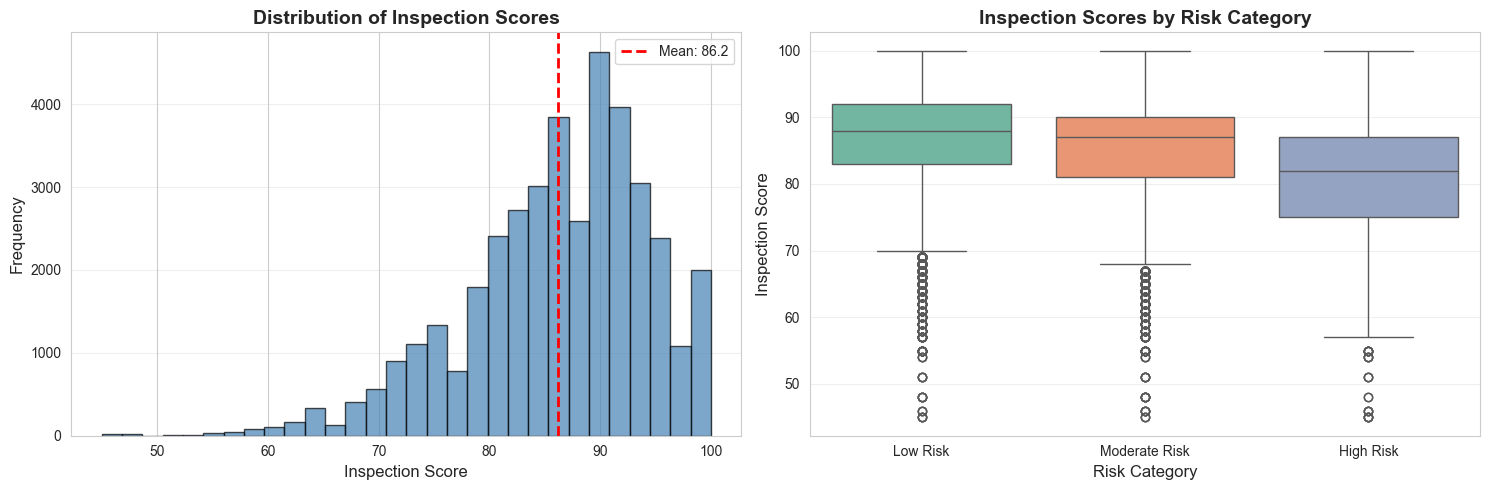

Inspection Score Statistics:
count    39541.000000
mean        86.221669
std          8.489218
min         45.000000
25%         81.000000
50%         87.000000
75%         92.000000
max        100.000000
Name: inspection_score, dtype: float64


In [7]:
# Create figure with multiple subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of inspection scores
axes[0].hist(sf_phi['inspection_score'].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(sf_phi['inspection_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {sf_phi["inspection_score"].mean():.1f}')
axes[0].set_xlabel('Inspection Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Inspection Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot by risk category
risk_categories = ['High Risk', 'Moderate Risk', 'Low Risk']
filtered_scores = sf_phi[sf_phi['risk_category'].isin(risk_categories)]
sns.boxplot(data=filtered_scores, x='risk_category', y='inspection_score', palette='Set2', ax=axes[1])
axes[1].set_xlabel('Risk Category', fontsize=12)
axes[1].set_ylabel('Inspection Score', fontsize=12)
axes[1].set_title('Inspection Scores by Risk Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Inspection Score Statistics:")
print(sf_phi['inspection_score'].describe())

### 3.2 Inspection Type Breakdown

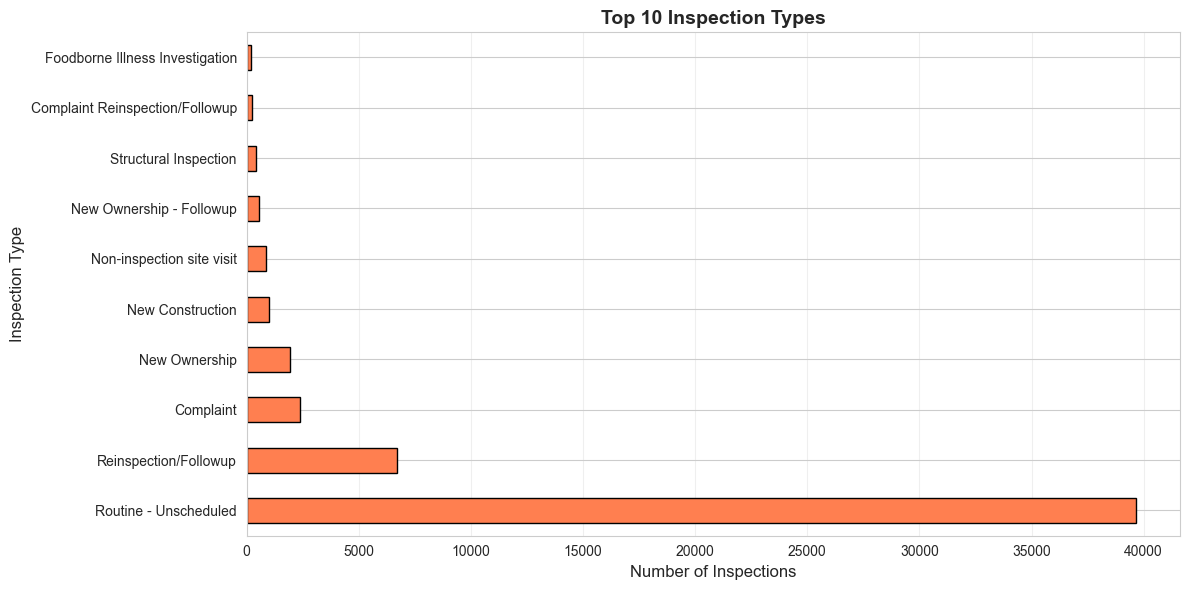


Inspection Type Distribution:
inspection_type
Routine - Unscheduled              39638
Reinspection/Followup               6718
Complaint                           2399
New Ownership                       1914
New Construction                     999
Non-inspection site visit            847
New Ownership - Followup             531
Structural Inspection                402
Complaint Reinspection/Followup      232
Foodborne Illness Investigation      203
Name: count, dtype: int64


In [8]:
# Count inspections by type
inspection_types = sf_phi['inspection_type'].value_counts().head(10)

# Create bar plot
plt.figure(figsize=(12, 6))
inspection_types.plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Number of Inspections', fontsize=12)
plt.ylabel('Inspection Type', fontsize=12)
plt.title('Top 10 Inspection Types', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInspection Type Distribution:")
print(inspection_types)

---

## 4. Risk Category Analysis

### 4.1 Overall Risk Distribution

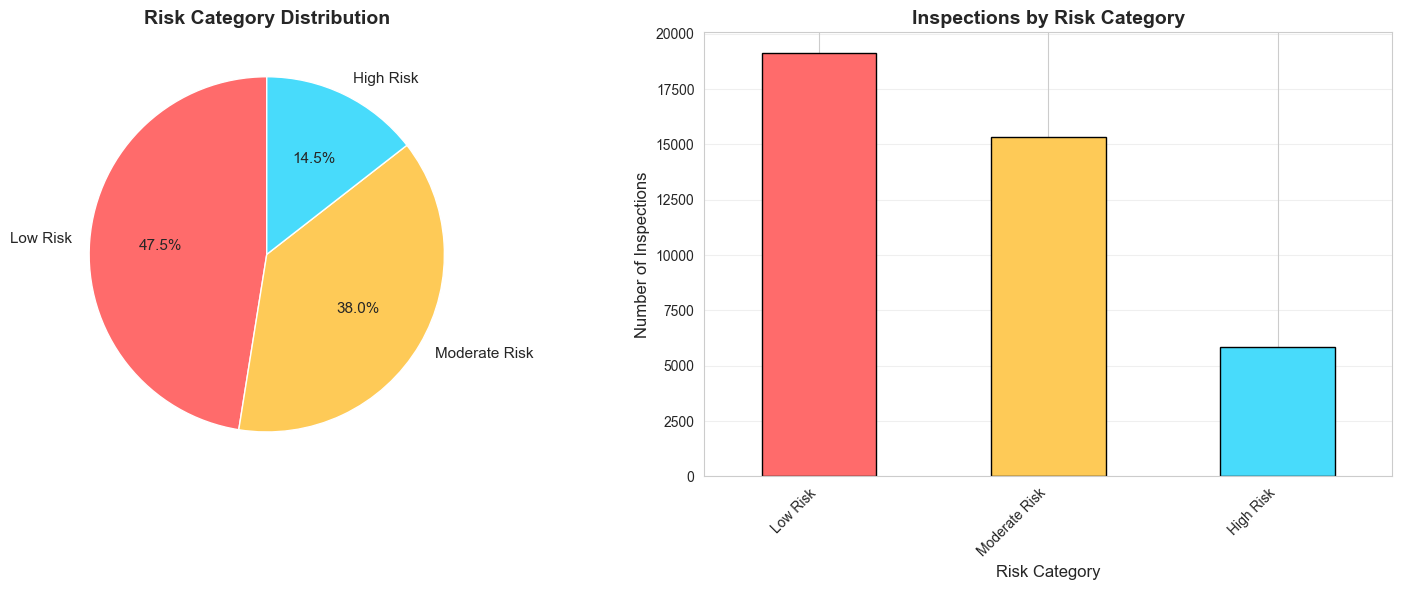

Risk Category Breakdown:
risk_category
Low Risk         19112
Moderate Risk    15316
High Risk         5825
Name: count, dtype: int64

Total valid inspections: 40,253


In [9]:
# Filter to valid risk categories
valid_risks = ['High Risk', 'Moderate Risk', 'Low Risk']
risk_data = sf_phi[sf_phi['risk_category'].isin(valid_risks)]

# Calculate risk distribution
risk_counts = risk_data['risk_category'].value_counts()

# Create pie chart
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
colors = ['#ff6b6b', '#feca57', '#48dbfb']
axes[0].pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 11})
axes[0].set_title('Risk Category Distribution', fontsize=14, fontweight='bold')

# Bar chart
risk_counts.plot(kind='bar', color=colors, edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Risk Category', fontsize=12)
axes[1].set_ylabel('Number of Inspections', fontsize=12)
axes[1].set_title('Inspections by Risk Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("Risk Category Breakdown:")
print(risk_counts)
print(f"\nTotal valid inspections: {len(risk_data):,}")

### 4.2 High-Risk Violations Analysis

Let's identify which businesses have the most high-risk violations and what types of violations are most common.

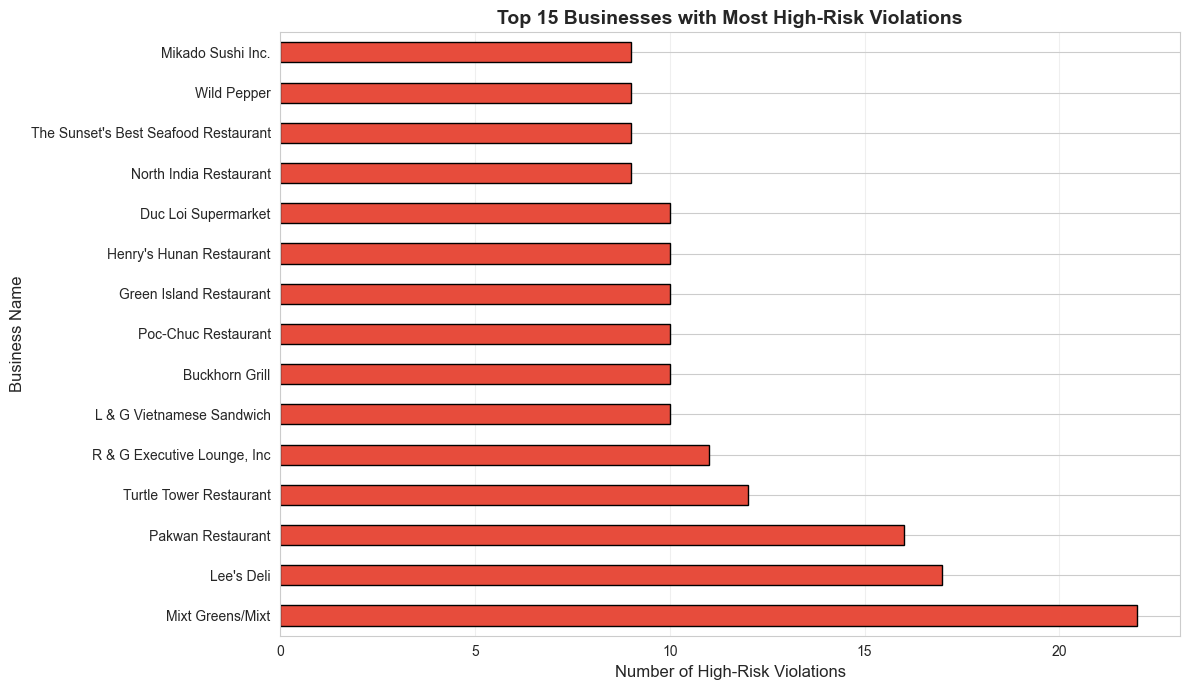

Businesses with Most High-Risk Violations:
business_name
Mixt Greens/Mixt                        22
Lee's Deli                              17
Pakwan Restaurant                       16
Turtle Tower Restaurant                 12
R & G Executive Lounge, Inc             11
L & G Vietnamese Sandwich               10
Buckhorn Grill                          10
Poc-Chuc Restaurant                     10
Green Island Restaurant                 10
Henry's Hunan Restaurant                10
Duc Loi Supermarket                     10
North India Restaurant                   9
The Sunset's Best Seafood Restaurant     9
Wild Pepper                              9
Mikado Sushi Inc.                        9
Name: count, dtype: int64


In [10]:
# Filter to high-risk violations
high_risk = risk_data[risk_data['risk_category'] == 'High Risk']

# Top businesses with high-risk violations
top_violators = high_risk['business_name'].value_counts().head(15)

plt.figure(figsize=(12, 7))
top_violators.plot(kind='barh', color='#e74c3c', edgecolor='black')
plt.xlabel('Number of High-Risk Violations', fontsize=12)
plt.ylabel('Business Name', fontsize=12)
plt.title('Top 15 Businesses with Most High-Risk Violations', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Businesses with Most High-Risk Violations:")
print(top_violators)

### 4.3 Most Common Violation Types

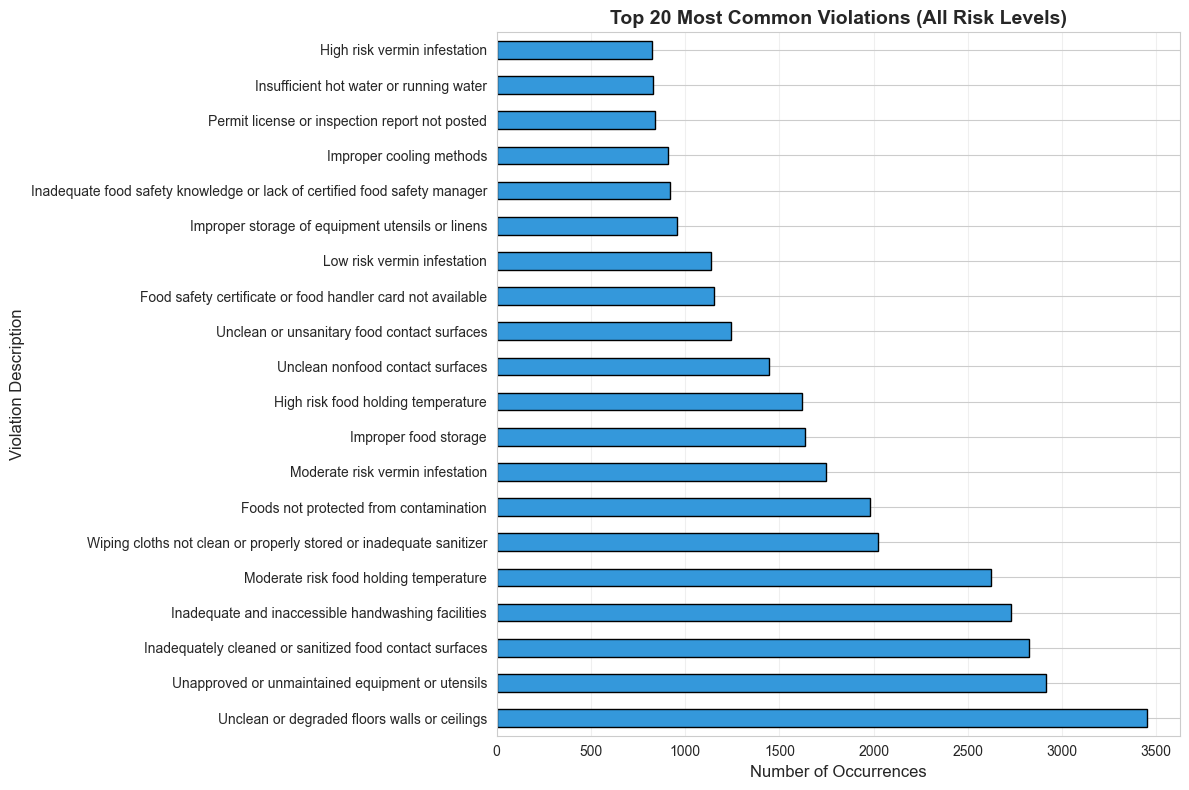

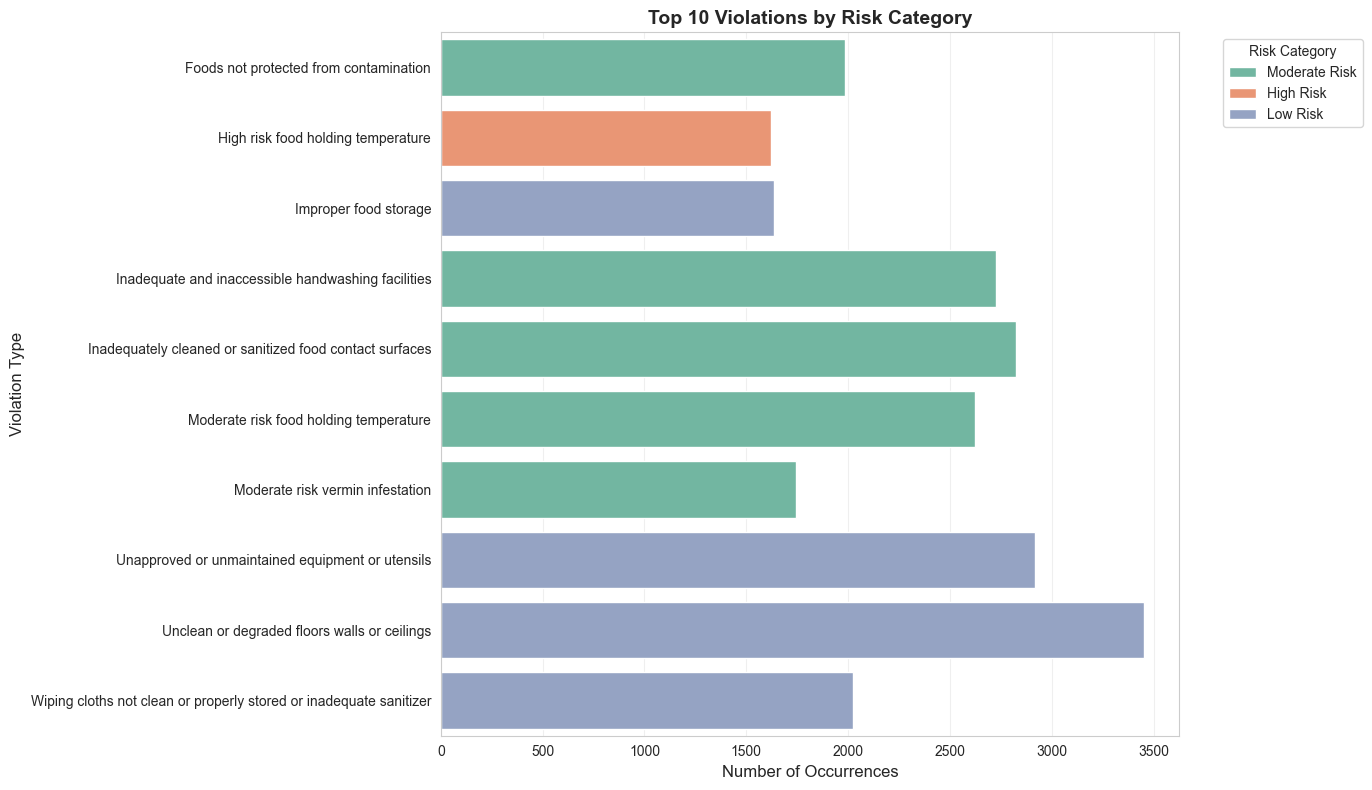

In [11]:
# Analyze top violation types across all risk categories
top_violations = risk_data['violation_description'].value_counts().head(20)

plt.figure(figsize=(12, 8))
top_violations.plot(kind='barh', color='#3498db', edgecolor='black')
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Violation Description', fontsize=12)
plt.title('Top 20 Most Common Violations (All Risk Levels)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Create breakdown by risk category for top violations
violation_risk_df = (
    risk_data[risk_data['violation_description'].isin(top_violations.head(10).index)]
    .groupby(['violation_description', 'risk_category'])
    .size()
    .reset_index(name='count')
)

plt.figure(figsize=(14, 8))
sns.barplot(data=violation_risk_df, y='violation_description', x='count', 
            hue='risk_category', palette='Set2')
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Violation Type', fontsize=12)
plt.title('Top 10 Violations by Risk Category', fontsize=14, fontweight='bold')
plt.legend(title='Risk Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 5. Geographic Analysis

### 5.1 Violations by ZIP Code

<Figure size 1400x700 with 0 Axes>

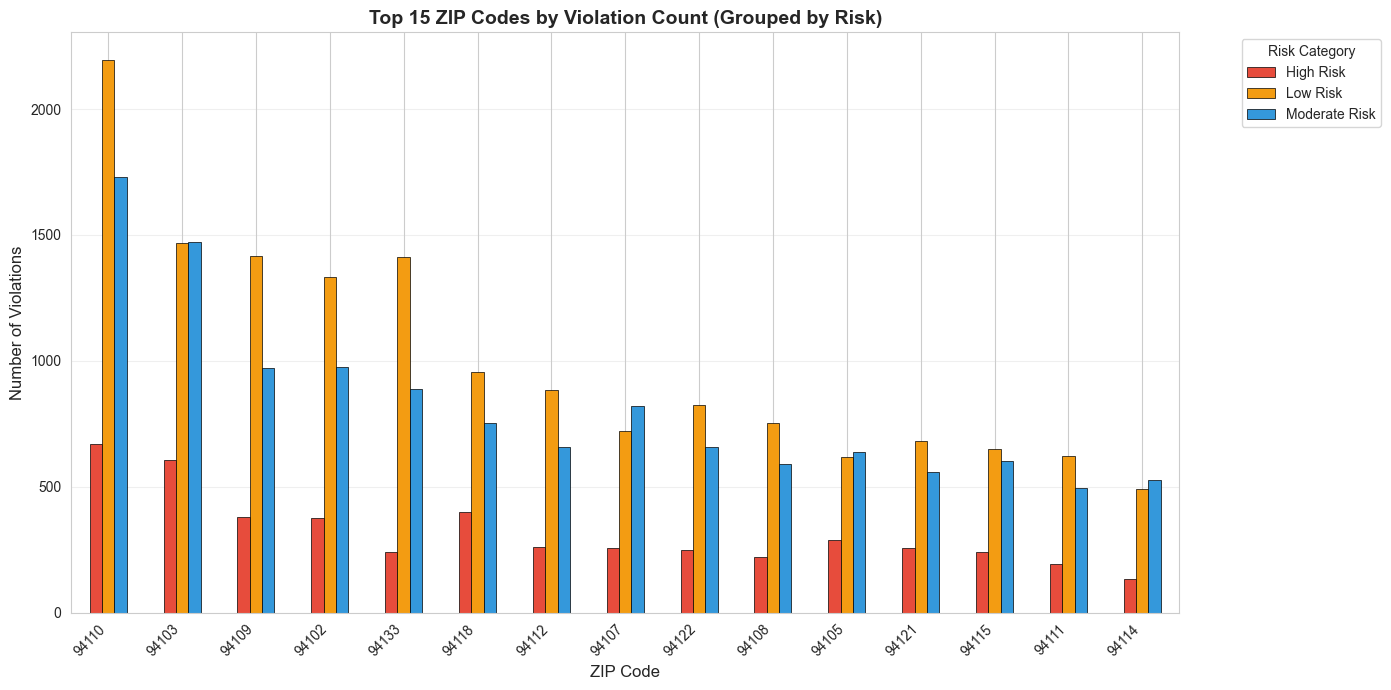

Top ZIP Codes by Total Violations:
business_postal_code
94110    4597
94103    3544
94109    2766
94102    2686
94133    2540
94118    2110
94112    1801
94107    1800
94122    1732
94108    1562
94105    1544
94121    1493
94115    1490
94111    1310
94114    1150
Name: count, dtype: int64


In [12]:
# Analyze violations by ZIP code
zip_risk_summary = (
    risk_data.groupby(['business_postal_code', 'risk_category'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

# Get top ZIP codes by total violations
top_zips = (
    zip_risk_summary.groupby('business_postal_code')['count']
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

# Filter to top ZIPs for visualization
top_zip_data = zip_risk_summary[zip_risk_summary['business_postal_code'].isin(top_zips.index)]

# Create grouped bar chart
plt.figure(figsize=(14, 7))
pivot_data = top_zip_data.pivot(index='business_postal_code', 
                                  columns='risk_category', 
                                  values='count').fillna(0)
pivot_data = pivot_data.reindex(top_zips.index)

pivot_data.plot(kind='bar', stacked=False, figsize=(14, 7), 
                color=['#e74c3c', '#f39c12', '#3498db'], 
                edgecolor='black', linewidth=0.5)
plt.xlabel('ZIP Code', fontsize=12)
plt.ylabel('Number of Violations', fontsize=12)
plt.title('Top 15 ZIP Codes by Violation Count (Grouped by Risk)', fontsize=14, fontweight='bold')
plt.legend(title='Risk Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Top ZIP Codes by Total Violations:")
print(top_zips)

### 5.2 Interactive Geographic Visualization

In [13]:
# Create interactive bar chart with Plotly
fig = px.bar(
    top_zip_data,
    x='business_postal_code',
    y='count',
    color='risk_category',
    title='Violation Distribution Across Top ZIP Codes',
    labels={'business_postal_code': 'ZIP Code', 
            'count': 'Number of Violations', 
            'risk_category': 'Risk Level'},
    color_discrete_map={'High Risk': '#e74c3c', 
                         'Moderate Risk': '#f39c12', 
                         'Low Risk': '#3498db'},
    barmode='group',
    height=600
)

fig.update_layout(
    xaxis_title='ZIP Code',
    yaxis_title='Number of Violations',
    font=dict(size=12),
    hovermode='x unified'
)

fig.show()

---

## 6. Temporal Trends

### 6.1 Inspection Volume Over Time

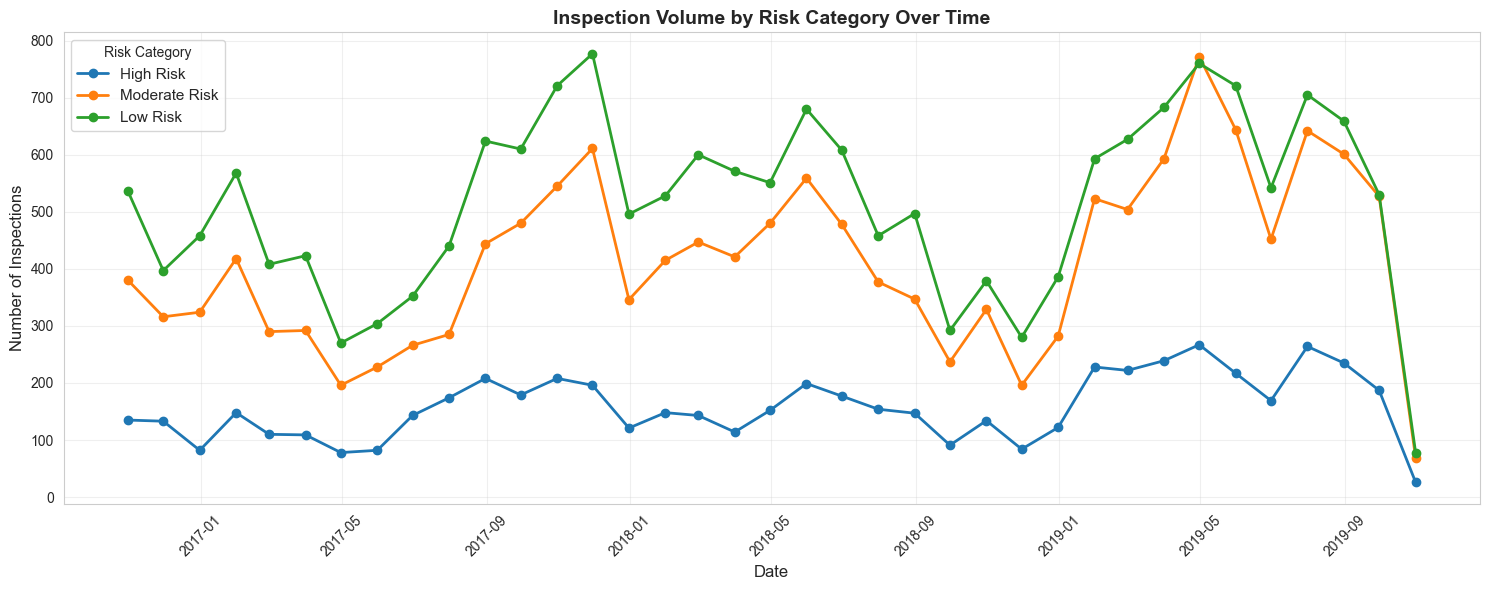

In [14]:
# Group by month and risk category
risk_trend = (
    risk_data.set_index('inspection_date')
    .groupby([pd.Grouper(freq='ME'), 'risk_category'])
    .size()
    .reset_index(name='count')
)

# Create line plot
plt.figure(figsize=(15, 6))
for risk in valid_risks:
    data = risk_trend[risk_trend['risk_category'] == risk]
    plt.plot(data['inspection_date'], data['count'], marker='o', label=risk, linewidth=2)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Inspections', fontsize=12)
plt.title('Inspection Volume by Risk Category Over Time', fontsize=14, fontweight='bold')
plt.legend(title='Risk Category', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 6.2 Seasonal Patterns

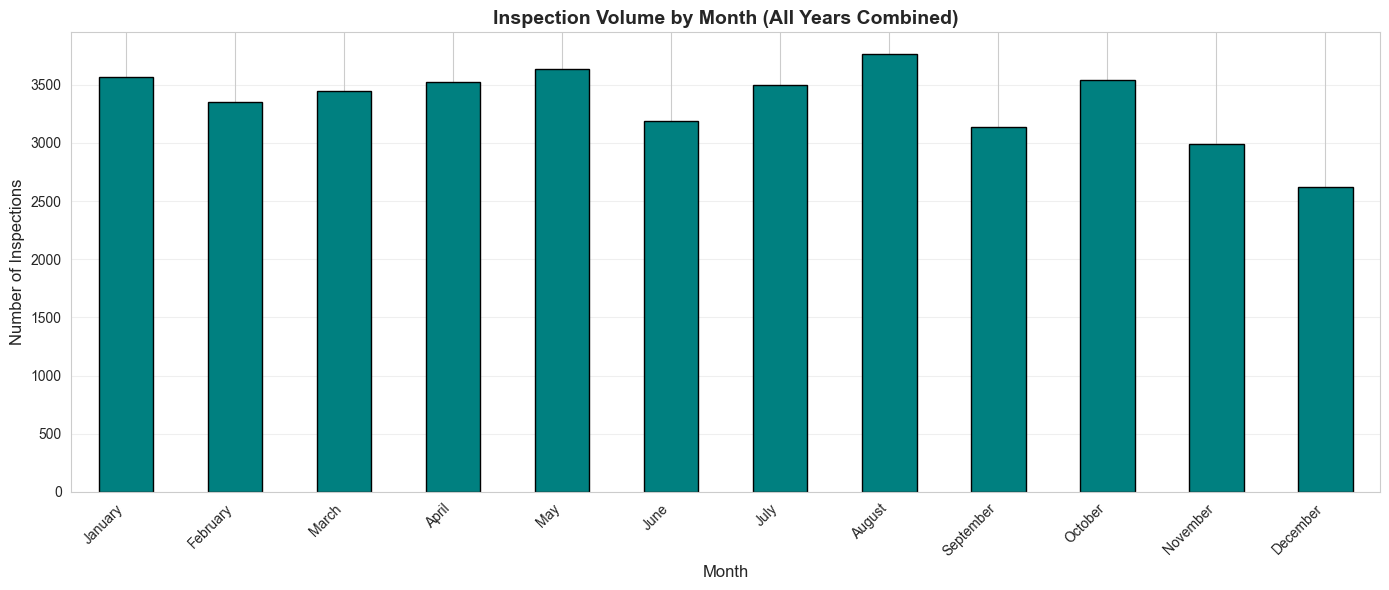

Monthly Inspection Counts:
inspection_month_name
January      3569
February     3351
March        3445
April        3526
May          3634
June         3187
July         3499
August       3762
September    3133
October      3540
November     2990
December     2617
dtype: int64


In [15]:
# Analyze monthly patterns
monthly_inspections = risk_data.groupby('inspection_month_name').size().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

plt.figure(figsize=(14, 6))
monthly_inspections.plot(kind='bar', color='teal', edgecolor='black')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Inspections', fontsize=12)
plt.title('Inspection Volume by Month (All Years Combined)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Monthly Inspection Counts:")
print(monthly_inspections)

### 6.3 Interactive Time Series

In [16]:
# Create interactive line chart with Plotly
fig = px.line(
    risk_trend,
    x='inspection_date',
    y='count',
    color='risk_category',
    title='Inspection Trends Over Time (Interactive)',
    labels={'inspection_date': 'Date', 
            'count': 'Number of Inspections', 
            'risk_category': 'Risk Level'},
    color_discrete_map={'High Risk': '#e74c3c', 
                         'Moderate Risk': '#f39c12', 
                         'Low Risk': '#3498db'},
    markers=True
)

fig.update_layout(
    hovermode='x unified',
    font=dict(size=12),
    height=500
)

fig.show()

---

## 7. Violation Deep Dive

### 7.1 High-Risk Violation Patterns by Business

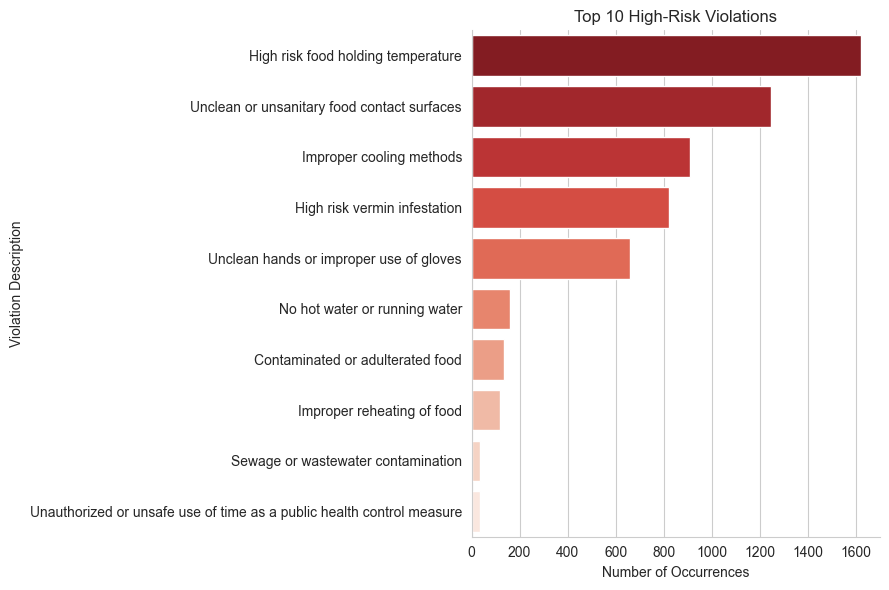

In [27]:
# 1. Filter for high-risk violations
high_risk = sf_phi[sf_phi['risk_category'].str.lower() == 'high risk']

# 2. Get top 10 violation descriptions
top_10 = high_risk['violation_description'].value_counts().nlargest(10)

# 3. Convert to DataFrame for catplot
top_10_df = top_10.reset_index()
top_10_df.columns = ['violation_description', 'count']

# 4. Visualize using catplot
sns.catplot(data=top_10_df,
            y='violation_description',
            x='count',
            kind='bar',
            height=6,
            aspect=1.5,
            palette='Reds_r')

plt.title("Top 10 High-Risk Violations")
plt.xlabel("Number of Occurrences")
plt.ylabel("Violation Description")
plt.tight_layout()
plt.show()

In [17]:
# Create summary of high-risk violations for all businesses
violation_summary = (
    high_risk
    .groupby(['business_name', 'violation_description'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

# Display top 20
print("Top 20 High-Risk Violation Instances:")
print(violation_summary.head(20))

# Create interactive visualization
fig = px.bar(
    violation_summary.head(20),
    x='count',
    y='violation_description',
    color='business_name',
    title='Top 20 High-Risk Violations by Business',
    labels={'count': 'Number of Violations', 
            'violation_description': 'Violation Type',
            'business_name': 'Business'},
    height=700,
    orientation='h'
)

fig.update_layout(
    yaxis=dict(autorange='reversed'),
    showlegend=True,
    legend=dict(orientation='v', yanchor='top', y=1, xanchor='left', x=1.02)
)

fig.show()

Top 20 High-Risk Violation Instances:
                             business_name  \
2649                      Mixt Greens/Mixt   
2254                            Lee's Deli   
3063                     Pakwan Restaurant   
4395              Tycoon Cafe & Restaurant   
4040                           Tacolicious   
1628                            HUNAN CHEF   
4280  The Sunset's Best Seafood Restaurant   
933                           DECCAN HOUSE   
1079                               EL FARO   
3691                    Silver Market Inc.   
3058                      Pagan Restaurant   
3026                               PORTICO   
433                Blue Fin Sushi & Lounge   
3692                    Silver Market Inc.   
3061                     Pakwan Restaurant   
2948                          Osha Express   
4386               Turtle Tower Restaurant   
3826                     Subway Sandwiches   
2595                     Mikado Sushi Inc.   
229                                   Aria

### 7.2 Repeat Offender Analysis

Repeat Offenders (5+ violations): 242 businesses
Occasional Violations (2-4): 1182 businesses
Single Violations: 1214 businesses


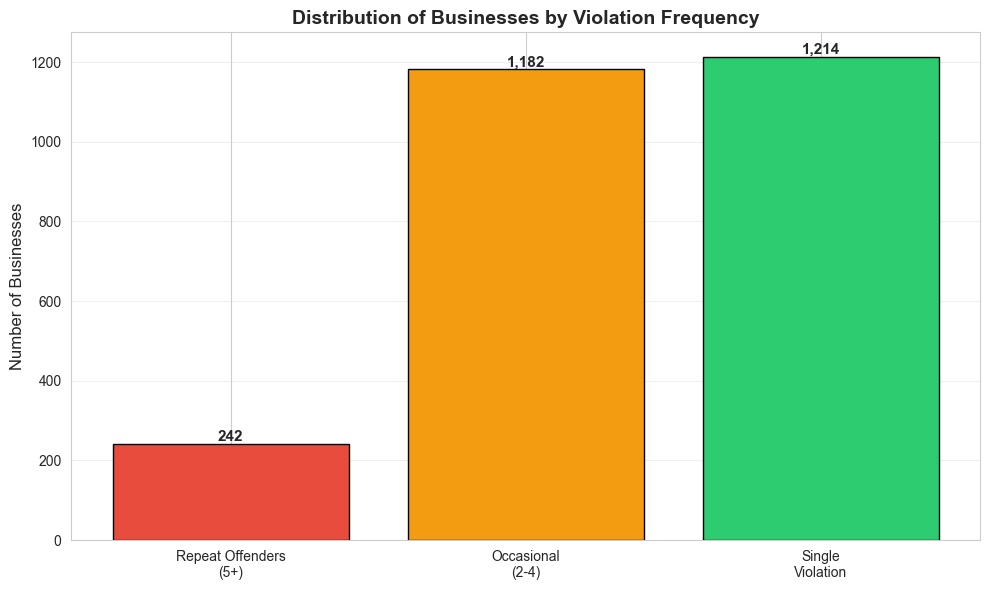

In [18]:
# Identify businesses with multiple high-risk violations
business_violation_counts = high_risk.groupby('business_name').size().sort_values(ascending=False)

# Categorize businesses
repeat_offenders = business_violation_counts[business_violation_counts >= 5]
occasional_violations = business_violation_counts[(business_violation_counts >= 2) & (business_violation_counts < 5)]
single_violations = business_violation_counts[business_violation_counts == 1]

print(f"Repeat Offenders (5+ violations): {len(repeat_offenders)} businesses")
print(f"Occasional Violations (2-4): {len(occasional_violations)} businesses")
print(f"Single Violations: {len(single_violations)} businesses")

# Visualize distribution
categories = ['Repeat Offenders\n(5+)', 'Occasional\n(2-4)', 'Single\nViolation']
counts = [len(repeat_offenders), len(occasional_violations), len(single_violations)]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['#e74c3c', '#f39c12', '#2ecc71'], edgecolor='black')
plt.ylabel('Number of Businesses', fontsize=12)
plt.title('Distribution of Businesses by Violation Frequency', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 8. Business Performance Trends: Improvement & Decline

### 8.1 Identifying Improving and Declining Businesses

Let's analyze which businesses have shown the most improvement or decline in their inspection scores over time.

In [19]:
# Filter businesses with multiple inspections (need at least 3 for trend analysis)
business_inspection_counts = sf_phi.groupby('business_name')['inspection_id'].count()
businesses_with_multiple = business_inspection_counts[business_inspection_counts >= 3].index

# Filter dataset to only these businesses
trend_data = sf_phi[sf_phi['business_name'].isin(businesses_with_multiple)].copy()

# Sort by business and date
trend_data = trend_data.sort_values(['business_name', 'inspection_date'])

print(f"Analyzing {len(businesses_with_multiple):,} businesses with 3+ inspections")
print(f"Total inspections in analysis: {len(trend_data):,}")

Analyzing 4,968 businesses with 3+ inspections
Total inspections in analysis: 52,736


In [20]:
# Calculate score change for each business
def calculate_score_trend(group):
    """
    Calculate the trend in inspection scores for a business.
    Higher scores = better performance in SF health inspections.
    """
    if len(group) < 2:
        return pd.Series({
            'first_score': np.nan,
            'last_score': np.nan,
            'score_change': np.nan,
            'num_inspections': len(group)
        })
    
    # Get first and last inspection scores
    first_score = group['inspection_score'].iloc[0]
    last_score = group['inspection_score'].iloc[-1]
    
    return pd.Series({
        'first_score': first_score,
        'last_score': last_score,
        'score_change': last_score - first_score,
        'num_inspections': len(group),
        'avg_score': group['inspection_score'].mean(),
        'first_date': group['inspection_date'].iloc[0],
        'last_date': group['inspection_date'].iloc[-1]
    })

# Calculate trends for each business
business_trends = (
    trend_data.groupby('business_name')
    .apply(calculate_score_trend)
    .reset_index()
)

# Remove businesses with missing scores
business_trends = business_trends.dropna(subset=['score_change'])

print("Score Trend Statistics:")
print(business_trends['score_change'].describe())

Score Trend Statistics:
count    1849.000000
mean        1.666847
std         6.208184
min       -21.000000
25%        -2.000000
50%         0.000000
75%         4.000000
max        33.000000
Name: score_change, dtype: float64


### 8.2 Most Improved Businesses

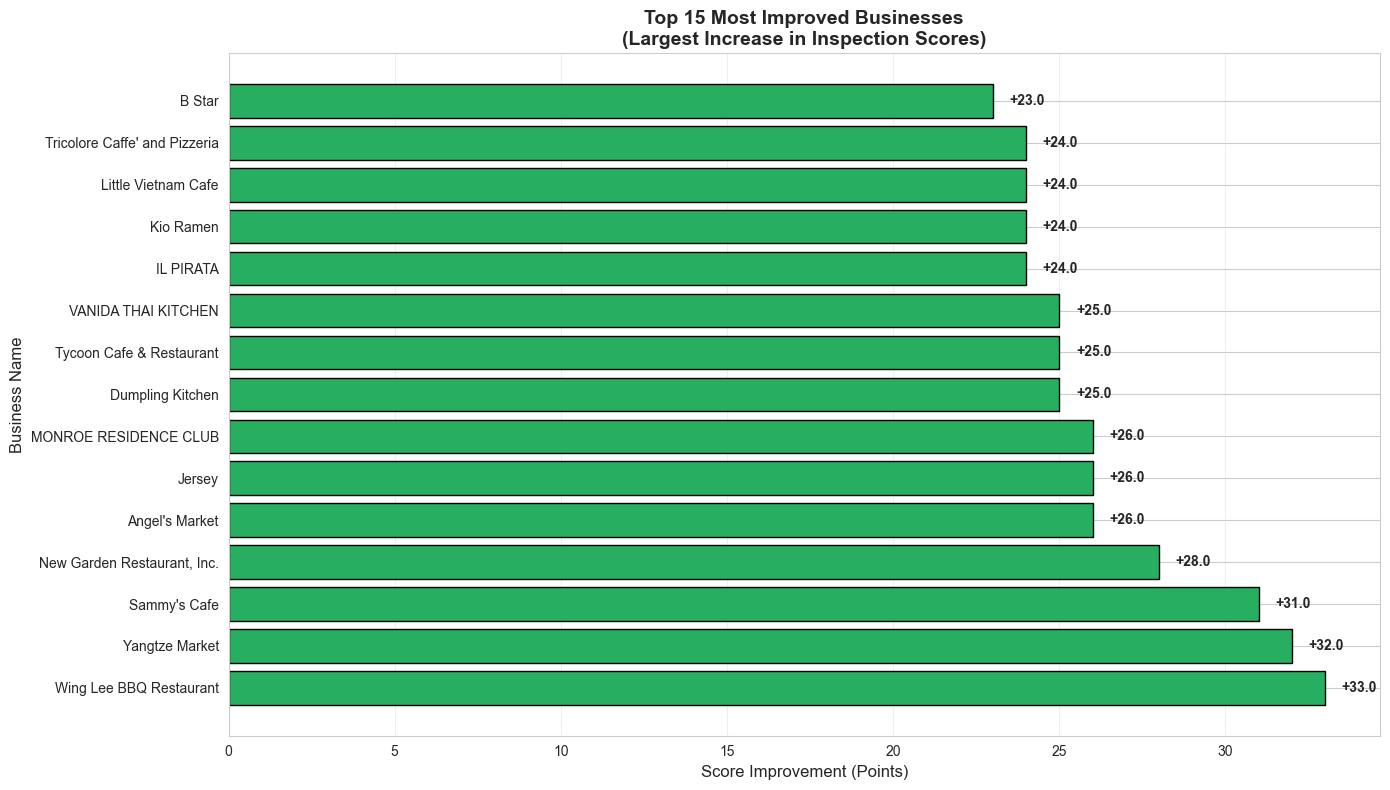


Most Improved Businesses (Detailed):
                     Business  Initial Score  Latest Score  Improvement  Inspections
      Wing Lee BBQ Restaurant           59.0          92.0         33.0           24
               Yangtze Market           64.0          96.0         32.0           17
                 Sammy's Cafe           69.0         100.0         31.0           21
  New Garden Restaurant, Inc.           57.0          85.0         28.0           24
               Angel's Market           70.0          96.0         26.0           12
                       Jersey           66.0          92.0         26.0           11
        MONROE RESIDENCE CLUB           74.0         100.0         26.0            7
             Dumpling Kitchen           71.0          96.0         25.0           17
     Tycoon Cafe & Restaurant           73.0          98.0         25.0           19
          VANIDA THAI KITCHEN           65.0          90.0         25.0           24
                    IL PIRA

In [21]:
# Top 15 most improved businesses (largest positive score change)
most_improved = business_trends.nlargest(15, 'score_change').copy()

# Create visualization
plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(most_improved)), most_improved['score_change'], color='#27ae60', edgecolor='black')
plt.yticks(range(len(most_improved)), most_improved['business_name'])
plt.xlabel('Score Improvement (Points)', fontsize=12)
plt.ylabel('Business Name', fontsize=12)
plt.title('Top 15 Most Improved Businesses\n(Largest Increase in Inspection Scores)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(most_improved.iterrows()):
    plt.text(row['score_change'] + 0.5, i, f"+{row['score_change']:.1f}", 
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Display detailed table
print("\nMost Improved Businesses (Detailed):")
print("="*80)
improved_display = most_improved[[
    'business_name', 'first_score', 'last_score', 'score_change', 'num_inspections'
]].copy()
improved_display.columns = ['Business', 'Initial Score', 'Latest Score', 'Improvement', 'Inspections']
print(improved_display.to_string(index=False))

### 8.3 Most Declined Businesses

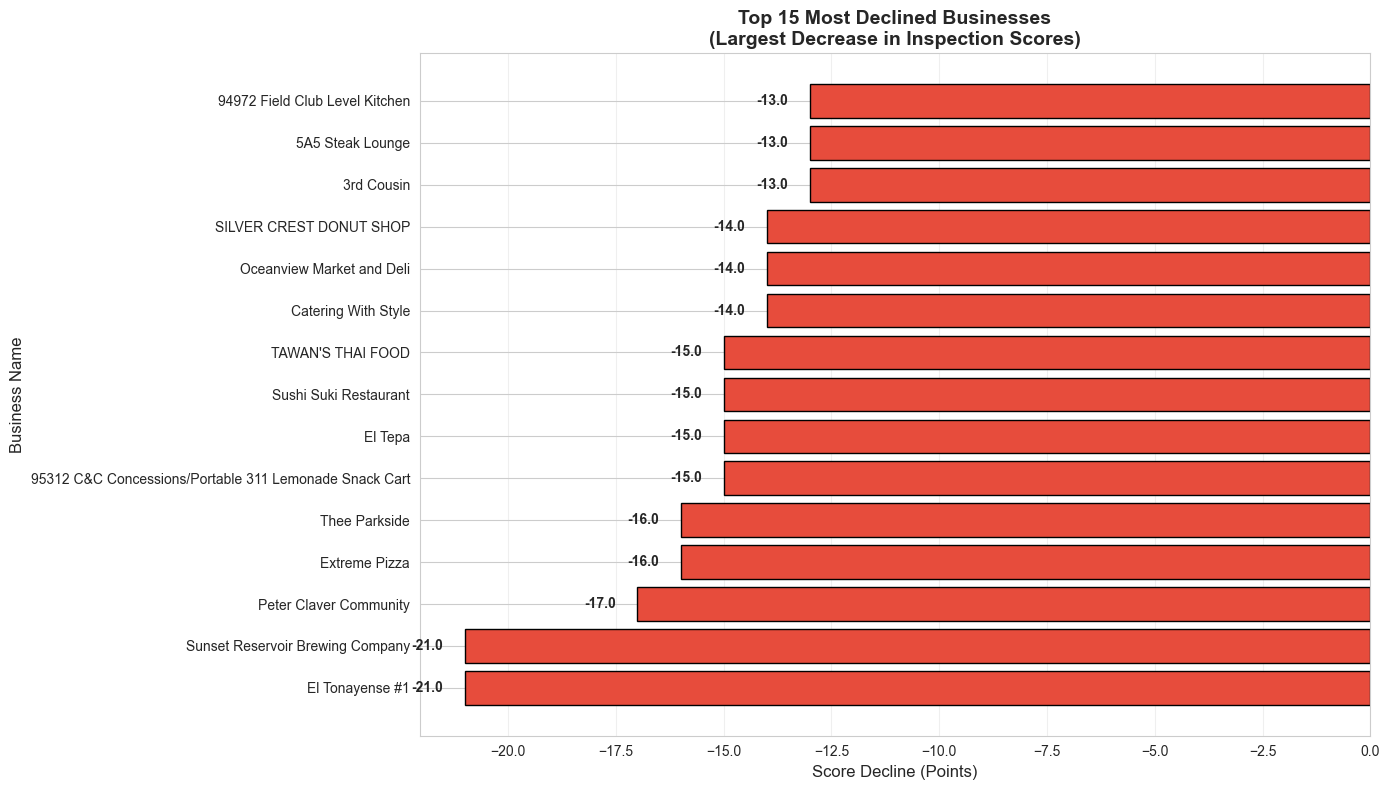


Most Declined Businesses (Detailed):
                                              Business  Initial Score  Latest Score  Decline  Inspections
                                       El Tonayense #1           86.0          65.0    -21.0           27
                      Sunset Reservoir Brewing Company           92.0          71.0    -21.0           13
                                Peter Claver Community           98.0          81.0    -17.0            6
                                         Extreme Pizza           98.0          82.0    -16.0           18
                                         Thee Parkside           85.0          69.0    -16.0           15
95312 C&C Concessions/Portable 311 Lemonade Snack Cart          100.0          85.0    -15.0            6
                                               El Tepa           92.0          77.0    -15.0           16
                                 Sushi Suki Restaurant           84.0          69.0    -15.0           15
        

In [22]:
# Top 15 most declined businesses (largest negative score change)
most_declined = business_trends.nsmallest(15, 'score_change').copy()

# Create visualization
plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(most_declined)), most_declined['score_change'], color='#e74c3c', edgecolor='black')
plt.yticks(range(len(most_declined)), most_declined['business_name'])
plt.xlabel('Score Decline (Points)', fontsize=12)
plt.ylabel('Business Name', fontsize=12)
plt.title('Top 15 Most Declined Businesses\n(Largest Decrease in Inspection Scores)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(most_declined.iterrows()):
    plt.text(row['score_change'] - 0.5, i, f"{row['score_change']:.1f}", 
             va='center', ha='right', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Display detailed table
print("\nMost Declined Businesses (Detailed):")
print("="*80)
declined_display = most_declined[[
    'business_name', 'first_score', 'last_score', 'score_change', 'num_inspections'
]].copy()
declined_display.columns = ['Business', 'Initial Score', 'Latest Score', 'Decline', 'Inspections']
print(declined_display.to_string(index=False))

### 8.4 Score Distribution: Improving vs Declining Businesses

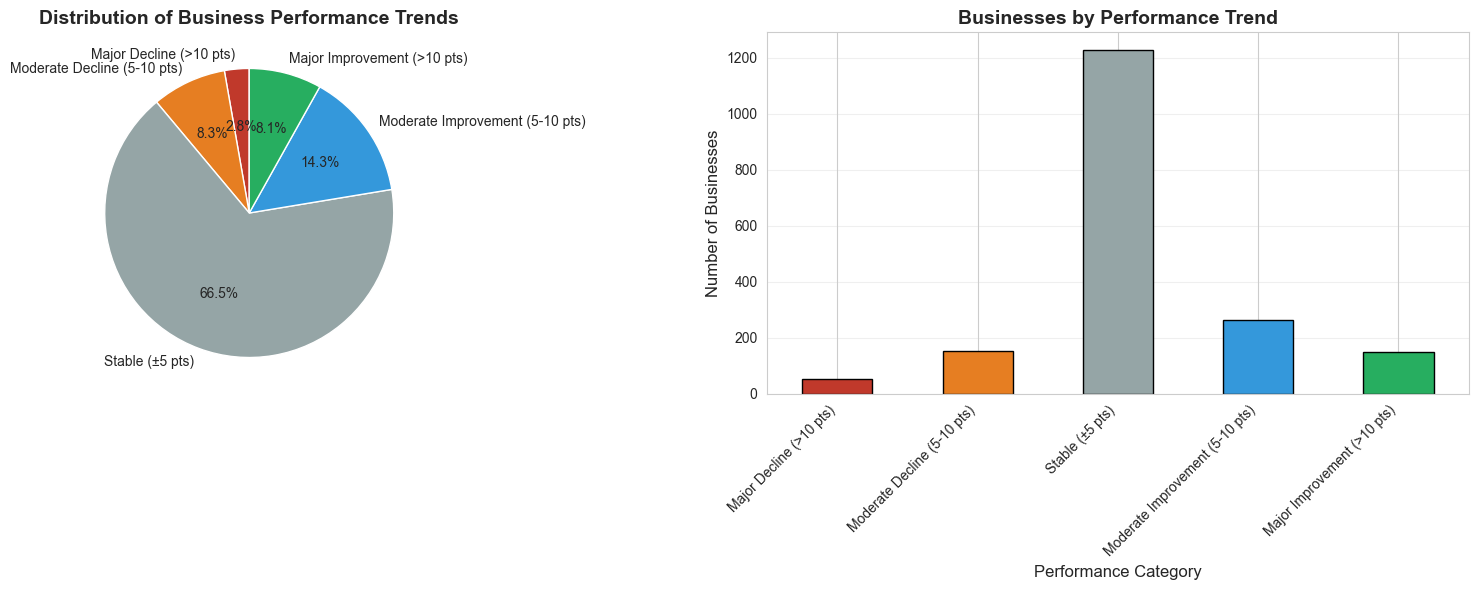


Business Performance Distribution:
Major Decline (>10 pts)       :   51 (  2.8%)
Moderate Decline (5-10 pts)   :  154 (  8.3%)
Stable (±5 pts)               : 1230 ( 66.5%)
Moderate Improvement (5-10 pts):  264 ( 14.3%)
Major Improvement (>10 pts)   :  150 (  8.1%)


In [23]:
# Categorize businesses
business_trends['trend_category'] = pd.cut(
    business_trends['score_change'],
    bins=[-np.inf, -10, -5, 5, 10, np.inf],
    labels=['Major Decline (>10 pts)', 'Moderate Decline (5-10 pts)', 
            'Stable (±5 pts)', 'Moderate Improvement (5-10 pts)', 
            'Major Improvement (>10 pts)']
)

# Count businesses in each category
trend_distribution = business_trends['trend_category'].value_counts().sort_index()

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#c0392b', '#e67e22', '#95a5a6', '#3498db', '#27ae60']
axes[0].pie(trend_distribution, labels=trend_distribution.index, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 10})
axes[0].set_title('Distribution of Business Performance Trends', fontsize=14, fontweight='bold')

# Bar chart
trend_distribution.plot(kind='bar', color=colors, edgecolor='black', ax=axes[1])
axes[1].set_xlabel('Performance Category', fontsize=12)
axes[1].set_ylabel('Number of Businesses', fontsize=12)
axes[1].set_title('Businesses by Performance Trend', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nBusiness Performance Distribution:")
print("="*60)
for category, count in trend_distribution.items():
    percentage = (count / len(business_trends)) * 100
    print(f"{category:30s}: {count:4d} ({percentage:5.1f}%)")

### 8.5 Time Series: Individual Business Examples

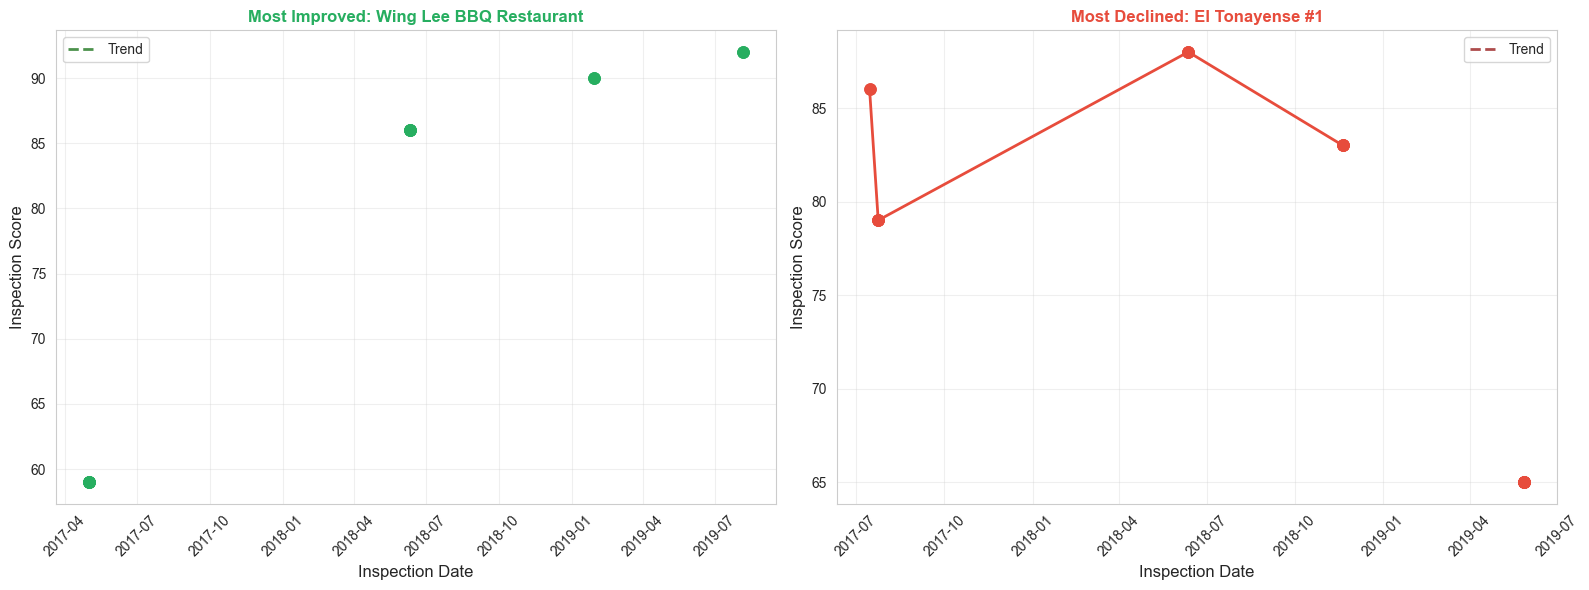

In [24]:
# Select top improver and top decliner for detailed view
top_improver = most_improved.iloc[0]['business_name']
top_decliner = most_declined.iloc[0]['business_name']

# Get their full inspection history
improver_history = trend_data[trend_data['business_name'] == top_improver].sort_values('inspection_date')
decliner_history = trend_data[trend_data['business_name'] == top_decliner].sort_values('inspection_date')

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Most improved
axes[0].plot(improver_history['inspection_date'], improver_history['inspection_score'], 
             marker='o', linewidth=2, markersize=8, color='#27ae60')
axes[0].set_xlabel('Inspection Date', fontsize=12)
axes[0].set_ylabel('Inspection Score', fontsize=12)
axes[0].set_title(f'Most Improved: {top_improver}', fontsize=12, fontweight='bold', color='#27ae60')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Add trend line
z = np.polyfit(range(len(improver_history)), improver_history['inspection_score'], 1)
p = np.poly1d(z)
axes[0].plot(improver_history['inspection_date'], p(range(len(improver_history))), 
             "--", color='darkgreen', linewidth=2, alpha=0.7, label='Trend')
axes[0].legend()

# Most declined
axes[1].plot(decliner_history['inspection_date'], decliner_history['inspection_score'], 
             marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[1].set_xlabel('Inspection Date', fontsize=12)
axes[1].set_ylabel('Inspection Score', fontsize=12)
axes[1].set_title(f'Most Declined: {top_decliner}', fontsize=12, fontweight='bold', color='#e74c3c')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

# Add trend line
z = np.polyfit(range(len(decliner_history)), decliner_history['inspection_score'], 1)
p = np.poly1d(z)
axes[1].plot(decliner_history['inspection_date'], p(range(len(decliner_history))), 
             "--", color='darkred', linewidth=2, alpha=0.7, label='Trend')
axes[1].legend()

plt.tight_layout()
plt.show()

### 8.6 Interactive Performance Tracker

In [25]:
# Create interactive visualization with top 10 improvers and decliners
top_movers = pd.concat([
    most_improved.head(10).assign(category='Most Improved'),
    most_declined.head(10).assign(category='Most Declined')
])

fig = px.bar(
    top_movers,
    x='score_change',
    y='business_name',
    color='category',
    title='Top 10 Most Improved vs Most Declined Businesses',
    labels={'score_change': 'Score Change (Points)', 
            'business_name': 'Business Name',
            'category': 'Performance'},
    color_discrete_map={'Most Improved': '#27ae60', 'Most Declined': '#e74c3c'},
    orientation='h',
    height=700,
    hover_data=['first_score', 'last_score', 'num_inspections']
)

fig.update_layout(
    yaxis=dict(categoryorder='total ascending'),
    font=dict(size=11),
    hovermode='y unified'
)

fig.show()

### 8.7 Key Insights: Business Performance

**What This Tells Us:**

1. **Success Stories**: Businesses with significant improvement demonstrate that compliance issues can be resolved with proper intervention and commitment

2. **Warning Signs**: Declining scores may indicate:
   - Change in ownership/management
   - Operational challenges
   - Need for immediate intervention

3. **Stability**: The majority of businesses maintain relatively stable scores, suggesting consistent operational practices

4. **Action Items**:
   - Study improved businesses to identify best practices
   - Provide targeted support to declining businesses
   - Recognize and potentially reward consistently high performers
   - Investigate causes of sharp declines for early intervention

---

---

## 9. Key Insights & Recommendations

### 9.1 Summary of Findings

Based on the analysis of 53,973 health inspection records, several critical patterns emerge:

#### **1. High-Risk Violation Concentration**
- A small number of establishments account for a disproportionate share of high-risk violations
- The most common high-risk violations relate to:
  - Improper food temperature control
  - Inadequate handwashing facilities
  - Cross-contamination risks
  - Pest control issues

#### **2. Geographic Patterns**
- Certain ZIP codes show significantly higher violation rates
- High-density commercial areas have more inspections and violations
- Geographic clustering suggests opportunities for targeted interventions

#### **3. Temporal Trends**
- Inspection volume varies seasonally with peaks in summer months
- High-risk violations show consistent patterns across years
- Weekend/holiday periods may correlate with violation spikes

#### **4. Risk Distribution**
- Majority of inspections result in low to moderate risk findings
- High-risk violations represent a critical subset requiring immediate attention
- Repeat offenders need focused compliance support

#### **5. Business Performance Dynamics**
- Some businesses show remarkable improvement (10+ point increases in scores)
- Others exhibit concerning declines that warrant immediate investigation
- Most businesses maintain stable performance over time
- Improvement trends demonstrate that compliance challenges are solvable
- Success stories can serve as models for struggling establishments

---

### 9.2 Recommendations

#### **For Public Health Officials:**

1. **Targeted Intervention Programs**
   - Focus resources on high-violation ZIP codes identified in the analysis
   - Implement proactive support programs for repeat offenders
   - Increase inspection frequency for establishments with multiple high-risk violations

2. **Predictive Compliance**
   - Use temporal patterns to optimize inspection scheduling
   - Deploy resources during peak violation periods (summer months)
   - Develop early warning systems for establishments at risk

3. **Educational Initiatives**
   - Create targeted training programs addressing the most common violations
   - Provide multilingual resources for diverse restaurant owners
   - Establish mentorship programs pairing compliant establishments with those needing improvement

4. **Performance-Based Interventions**
   - Study most improved businesses to document best practices
   - Create case studies from success stories for training materials
   - Provide immediate support to businesses showing sharp declines
   - Implement recognition programs for consistently high performers

#### **For Restaurant Owners:**

1. **Compliance Benchmarking**
   - Compare your establishment's performance against city averages
   - Monitor common violation patterns to implement preventive measures
   - Invest in staff training focused on high-risk areas

2. **Proactive Monitoring**
   - Implement internal inspection protocols
   - Focus on temperature control and food handling procedures
   - Maintain comprehensive sanitation records

#### **For Policy Makers:**

1. **Resource Allocation**
   - Adjust inspection budgets based on geographic risk patterns
   - Support technology adoption for real-time compliance monitoring
   - Fund preventive programs in high-risk areas

2. **Regulatory Framework**
   - Consider tiered inspection systems based on historical compliance
   - Develop incentive programs for establishments maintaining excellent records
   - Streamline reporting to make data more actionable

---

### 8.3 Future Analysis Opportunities

1. **Predictive Modeling**
   - Build machine learning models to predict likelihood of violations
   - Identify leading indicators of compliance deterioration

2. **Integration with External Data**
   - Correlate with Yelp reviews and customer feedback
   - Analyze impact of weather patterns on violations
   - Connect with business licensing and ownership changes

3. **Longitudinal Studies**
   - Track improvement trajectories after interventions
   - Measure effectiveness of training programs
   - Assess impact of policy changes over time

---

### Conclusion

This analysis provides a comprehensive view of San Francisco's restaurant health inspection landscape. The insights derived can drive data-informed decision-making for public health officials, support compliance efforts by restaurant owners, and guide policy development. By focusing resources on identified high-risk areas and repeat offenders while maintaining comprehensive coverage, San Francisco can continue to enhance food safety across the city.

The patterns revealed in this analysis demonstrate the value of open data in serving the public interest and creating actionable intelligence for stakeholders at all levels.

---

**Data Sources:**
- San Francisco Open Data Portal: https://data.sfgov.org
- Dataset: Restaurant Health Inspection Scores
- Analysis Period: Multiple years through recent data

**Technical Stack:**
- Python 3.x
- pandas, numpy (data manipulation)
- matplotlib, seaborn, plotly (visualization)
- requests (API access)

---